In [26]:
import tensorflow as tf
import numpy as np
import seaborn as sns
from tensorflow import keras
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [27]:
# Define the image data generators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory("COVID-CT-master/Dataset/train/",
                                          target_size=(150,150),
                                          batch_size = 32,
                                          class_mode = 'binary')
                                         
test_generator = test_datagen.flow_from_directory("COVID-CT-master/Dataset/test/",
                                          target_size=(150,150),
                                          batch_size =32,
                                          class_mode = 'binary')

val_generator = val_datagen.flow_from_directory("COVID-CT-master/Dataset/val/",
                                          target_size=(150,150),
                                          batch_size =32,
                                          class_mode = 'binary')

Found 425 images belonging to 2 classes.
Found 203 images belonging to 2 classes.
Found 118 images belonging to 2 classes.


### Extract X_train, y_train, X_test, y_test for a part of the data. NO LOOP OVER GENERATOR

In [28]:
# Extract the X_train and y_train arrays from the training generator
#X_train, y_train = next(train_generator)

# Extract the X_test and y_test arrays from the testing generator
#X_test, y_test = next(test_generator)

### Extract X_train, y_train, X_test, y_test for a part of the data. LOOP OVER GENERATOR

In [29]:
# Get the number of samples in the training and testing generators
train_samples = len(train_generator.filenames)
test_samples = len(test_generator.filenames)
val_samples = len(val_generator.filenames)

# Calculate the number of batches for the training and testing data
train_batches = train_samples // 32 + (1 if train_samples % 32 else 0)
test_batches = test_samples // 32 + (1 if test_samples % 32 else 0)
val_batches = val_samples // 32 + (1 if val_samples % 32 else 0)

# Create empty arrays to store the training and testing data
X_train = np.zeros((train_samples, 150, 150, 3))
y_train = np.zeros((train_samples,))
X_test = np.zeros((val_samples, 150, 150, 3))
y_test = np.zeros((val_samples,))
"""
X_test = np.zeros((test_samples, 150, 150, 3))
y_test = np.zeros((test_samples,))
"""

# Fill the arrays with the training and testing data
for i, (x, y) in enumerate(train_generator):
    start = i * 32
    end = min(start + 32, train_samples)
    X_train[start:end] = x[:end-start]
    y_train[start:end] = y[:end-start]
    if end == train_samples:
        break
"""
for i, (x, y) in enumerate(test_generator):
    start = i * 32
    end = min(start + 32, test_samples)
    X_test[start:end] = x[:end-start]
    y_test[start:end] = y[:end-start]
    if end == test_samples:
        break
"""

for i, (x, y) in enumerate(val_generator):
    start = i * 32
    end = min(start + 32, val_samples)
    X_test[start:end] = x[:end-start]
    y_test[start:end] = y[:end-start]
    if end == val_samples:
        break


In [30]:
def preprocess_image(image):
    image = tf.image.resize(image, (150, 150))
    image = (image - 127.5) / 127.5
    return image

def create_first_cnn():
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    return model

def create_second_cnn():
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(150, 150, 3)))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    return model

def create_cascading_cnn_pipeline(first_cnn, second_cnn):
    input_image = keras.Input(shape=(150, 150, 3))
    processed_image = keras.layers.Lambda(preprocess_image)(input_image)
    first_cnn_output = first_cnn(processed_image)
    second_cnn_input = keras.layers.multiply([processed_image, first_cnn_output])
    second_cnn_output = second_cnn(second_cnn_input)
    return keras.Model(inputs=input_image, outputs=second_cnn_output)

In [31]:
first_cnn = create_first_cnn()
first_cnn.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 17, 17, 128)     

In [32]:
second_cnn = create_second_cnn()
second_cnn.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 74, 74, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 72, 72, 128)       73856     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 36, 36, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 34, 34, 256)       295168    
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 17, 17, 256)     

In [33]:
cascading_cnn = create_cascading_cnn_pipeline(first_cnn, second_cnn)

# compile cascading cnn
cascading_cnn.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

# fit cascading cnn
#cascading_cnn.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))
cascading_cnn.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=val_generator)

Epoch 1/10


2023-02-11 10:09:32.298917: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - ETA: 0s - loss: 0.8113 - accuracy: 0.5365

2023-02-11 10:09:37.431494: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 6s 386ms/step - loss: 0.8113 - accuracy: 0.5365 - val_loss: 0.7106 - val_accuracy: 0.4915
Epoch 2/10
14/14 [==============================] - 5s 354ms/step - loss: 0.6926 - accuracy: 0.5506 - val_loss: 0.6948 - val_accuracy: 0.4915
Epoch 3/10
14/14 [==============================] - 4s 323ms/step - loss: 0.6952 - accuracy: 0.5506 - val_loss: 0.6961 - val_accuracy: 0.4915
Epoch 4/10
14/14 [==============================] - 5s 335ms/step - loss: 0.6891 - accuracy: 0.5506 - val_loss: 0.6981 - val_accuracy: 0.4915
Epoch 5/10
14/14 [==============================] - 4s 323ms/step - loss: 0.6906 - accuracy: 0.5506 - val_loss: 0.6974 - val_accuracy: 0.4915
Epoch 6/10
14/14 [==============================] - 5s 330ms/step - loss: 0.6896 - accuracy: 0.5506 - val_loss: 0.6945 - val_accuracy: 0.4915
Epoch 7/10
14/14 [==============================] - 5s 334ms/step - loss: 0.6899 - accuracy: 0.5506 - val_loss: 0.6957 - val_accuracy: 0.4915
Epoch 8/10
14/14 

In [34]:
# evaluate cascading cnn
score = cascading_cnn.evaluate(X_test, y_test)

print('Test score:', score[0])
print('Test accuracy:', score[1])

4/4 [==============================] - 0s 89ms/step - loss: 0.6970 - accuracy: 0.4915
Test score: 0.697012186050415
Test accuracy: 0.49152541160583496


1/4 [======>.......................] - ETA: 0s

2023-02-11 10:10:20.220113: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 101ms/step


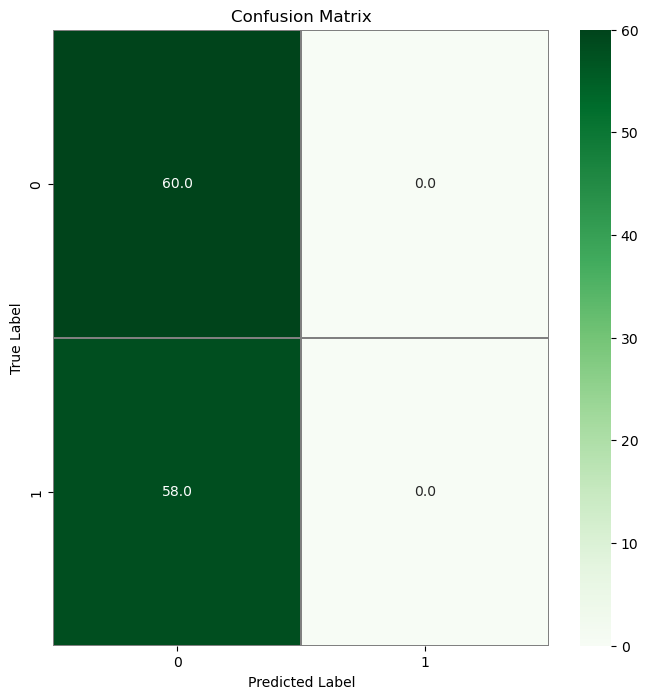

In [35]:
# predict on test data
y_pred = cascading_cnn.predict(X_test)

# convert predictions classes to one hot vectors
y_pred_classes = np.argmax(y_pred, axis=1)

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_test, y_pred_classes)

# plot the confusion matrix
f, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01, cmap="Greens", linecolor="gray", fmt= '.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [36]:
# predict probabilities for test set
yhat_probs = cascading_cnn.predict(X_test, verbose=0)
# predict crisp classes for test set
yhat_classes = cascading_cnn.predict_classes(X_test, verbose=0)

# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat_classes)
print('F1 score: %f' % f1)

# kappa
kappa = cohen_kappa_score(y_test, yhat_classes)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, yhat_probs)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_test, yhat_classes)
print(matrix)

# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, yhat_probs)
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.', label='Cascading CNN')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, yhat_probs)
# plot the precision-recall curve for the model
plt.plot(recall, precision, marker='.', label='Cascading CNN')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

AttributeError: 'Functional' object has no attribute 'predict_classes'